<p align="center">
    <a href="https://predict-idlab.github.io/landmarker">
        <img alt="landmarker" src="https://raw.githubusercontent.com/predict-idlab/landmarker/main/docs/_static/images/logo.svg" width="66%">
    </a>
</p>

# Training and Evaluating Adaptive Heatmap Regression Model for Landmark Detection with ISBI 2015 Cephalometric X-ray Dataset

In this tutorial, we will train and evaluate an adaptive heatmap regression model for landmark 
detection with the ISBI 2015 Cephalometric X-ray dataset. The ISBI 2015 Cephalometric X-ray dataset
is a dataset of 2D cephalometric X-rays. The dataset contains 400 images, each with 19 landmarks
annotated. The dataset is split into a training set of 150 images and two test sets of 150 and
100 images respectively.

We will go through the following steps:
* [Loading the dataset](#Loading-the-dataset)
* [Constructing a heatmap generator](#Constructing-a-heatmap-generator)
* [Inspecting the dataset](#Inspecting-the-dataset)
* [Training and initializing the SpatialConfiguration model](#Training-the-model)
* [Evaluating the model](#Evaluating-the-model)

<a target="_blank" href="https://colab.research.google.com/github/predict-idlab/landmarker/examples/adaptive_scn_isbi2015.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Setup environment

In [1]:
!python -c "import landmarker" || pip install landmarker

## Setup imports and variables

In [2]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from monai.transforms import (Compose, RandAffined, RandGaussianNoised, RandStdShiftIntensityd,
                              RandScaleIntensityd, RandAdjustContrastd, RandHistogramShiftd)
from tqdm import tqdm

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Loading the dataset

### Short description of the data and dataset module
The [landmarker](https://github.com/predict-idlab/landmarker) package has several built-in
datasets in the `landmarker.datasets` module, as well as utility classes for building your own
datasets in the `landmarker.data` module. There are three types of datasets: 'LandmarkDataset',
'HeatmapDataset', and 'MaskDataset'. The 'LandmarkDataset' is a dataset of images with landmarks,
the 'HeatmapDataset' is a dataset of images with heatmaps, and the 'MaskDataset' is a dataset of
images with masks (i.e., binary segmentation masks indiciating the location of the landmarks). The 
'HeatmapDataset' and 'MaskDataset' both inherit from the 'LandmarkDataset' class, and thus also 
contain information about the landmarks. The 'MaskDataset' can be constructed from specified image 
and landmarks pairs, or from images and masks pairs, because often that is how the data is
distributed. The 'HeatmapDataset' can be constructed from images and landmarks pairs.

Images can be provided as a list of paths to stored images, or as a a numpy arary, torch tensor, 
list of numpy  arrays or list of torch tensors. Landmarks can be as numpy arrays or torch tensors.
These landmarks can be provided in three different shapes: (1) (N, D) where N is the number of
samples and D is the number of dimensions, (2) (N, C, D) where C is the number of landmark
classes, (3) (N, C, I, D) where I is the number of instances per landmark class, if less than I
instances are provided, the remaining instances are filled with NaNs.

For built-in datasets, the `landmarker.datasets` module provides a function for
downloading and loading the dataset, e.g. `get_cepha_landmark_datasets` for the ISBI 2015 
Cephalometric X-ray dataset. Most of these functions take the same arguments, namely `path_dir`,
some are dataset specific. The `path_dir` argument specifies the directory where the dataset is
downloaded to, or loaded from if it is already downloaded. For most datasets multiple functions
are provided for getting different types of datasets. For example, the ISBI 2015 Cephalometric
X-ray dataset has the following functions: `get_cepha_landmark_datasets` and 
`get_cepha_heatmap_datasets`.

### Download and load ISBI 2015 landmark dataset
The ISBI 2015 Cephalometric X-ray dataset is a dataset of 2D cephalometric X-ray images with 19
landmarks. The dataset is split into a training set of 150 images and two test sets, where test
set  1 contains 150 images and test set 2 contains 100 images. When loading the dataset, you can
also specify a transform function, which is applied to the images and landmarks of the training
set. Currently, we only support the `monai.transforms.ComposeD transform, which allows you to
compose multiple transforms. The `monai.transforms` module contains many useful transforms, such
as `RandomAffine` and `NormalizeIntensity`. The transforms must be dictionary transforms, i.e.,
they must return a dictionary with the keys 'image' and ('seg'), in the case of heatmap and mask
regression.

In [4]:
fn_keys = ('image', )
spatial_transformd = [RandAffined(fn_keys, prob=1,
                        rotate_range=(-np.pi/12, np.pi/12),
                        translate_range=(-10, 10),
                        scale_range=(-0.1, 0.1),
                        shear_range=(-0.1, 0.1)
                        )]

composed_transformd = Compose(spatial_transformd +
                            [RandGaussianNoised(('image', ), prob=0.1, mean=0, std=0.005),  # Add gaussian noise
                        RandStdShiftIntensityd(('image', ), prob=0.1, factors=0.1),  # Add random intensity shift
                        RandScaleIntensityd(('image', ), factors=0.25, prob=0.1),  # Add random intensity scaling
                        RandAdjustContrastd(('image', ), prob=0.1, gamma=(0.5,2)),  # Randomly adjust contrast
                        RandHistogramShiftd(('image', ), prob=0.1),  # Randomly shift histogram
                        ])


In [5]:
from landmarker.datasets import get_cepha_landmark_datasets

ds = get_cepha_landmark_datasets("data", transform=composed_transformd,
                                 store_imgs = True, dim_img=(512, 512),
                                 junior = True, single_dataset = True)

Reading, normalizing and resizing 400 images and landmarks...


  0%|          | 0/400 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 400/400 [00:08<00:00, 48.59it/s]


In [6]:
split_lengths = [200, 100, 100]
ds_train, ds_val, ds_test = torch.utils.data.random_split(ds, split_lengths)

## Constructing a heatmap generator
The heatmap generator is a class that generates heatmaps from landmarks. It is used to generate
heatmaps from the landmarks of the training set, which are then used to train the model. The
`landmarker.heatmap_generator` module contains several heatmap generators, such as the
`GaussianHeatmapGenerator` and `LaplaceHeatmapGenerator` which generate a multivariate 
Gaussian and Laplace distribution respectively. The HeatmapGenerator subclasses take the following
arguments:
* `sigmas`: the standard deviation of the Gaussian distribution, or the scale of the Laplace. This 
could be a scalar, or a list of scalars, one for each landmark class. Additionally, it could be a
covariance matrix, or a list of covariance matrices, one for each landmark class.
* `gamma`: If provided, the heatmaps are scaled by `gamma` before being returned.
* `rotation`: If provided, the heatmaps are rotated by `rotation` before being returned.
* `heatmap_size`: The size of the returned heatmaps.
* learnable: If True, the `sigma` and `rotation` parameters are learnable parameters, and thus
will be optimized during training.
* `background`: A boolean indicating whether to add a background class to the heatmaps. If True,
the heatmaps will have an additional channel, which is 1 everywhere except at the location of the
landmarks, where it is 0. The background class is the first class, i.e., the first channel.
* `all_points`: A boolean indicating whether to add a channel with all the landmarks. If True, the
heatmaps will have an additional channel, which is 1 at the location of the landmarks, and 0.
everywhere else.
* `continuous`: A boolean indicating whether to use continuous or discrete landmarks.
* `device`: The device on which the heatmaps are generated.

The landmarks provide to the heatmap generator must be a torch.Tensor and can be in three different 
shapes: (1) (N, D) where N is the number of samples and D is the number of dimensions, (2) (N, C, D)
where C is the number of landmark classes, (3) (N, C, I, D) where I is the number of instances per
landmark class, if less than I instances are provided, the remaining instances are filled with NaNs.
The heatmap generator will return a torch.Tensor of shape (N, C, H, W), where H and W are the height
and width of the heatmaps respectively.

**Note that with 2D landmarks the y coordinates are the first dimension, and the x coordinates are the
second dimension.**

In [7]:
from landmarker.heatmap.generator import GaussianHeatmapGenerator

heatmap_generator = GaussianHeatmapGenerator(
    nb_landmarks=19,
    sigmas=3,
    gamma=100,
    heatmap_size=(512, 512),
    learnable=True, # If True, the heatmap generator will be trainable
    device=device
)

## Inspecting the dataset

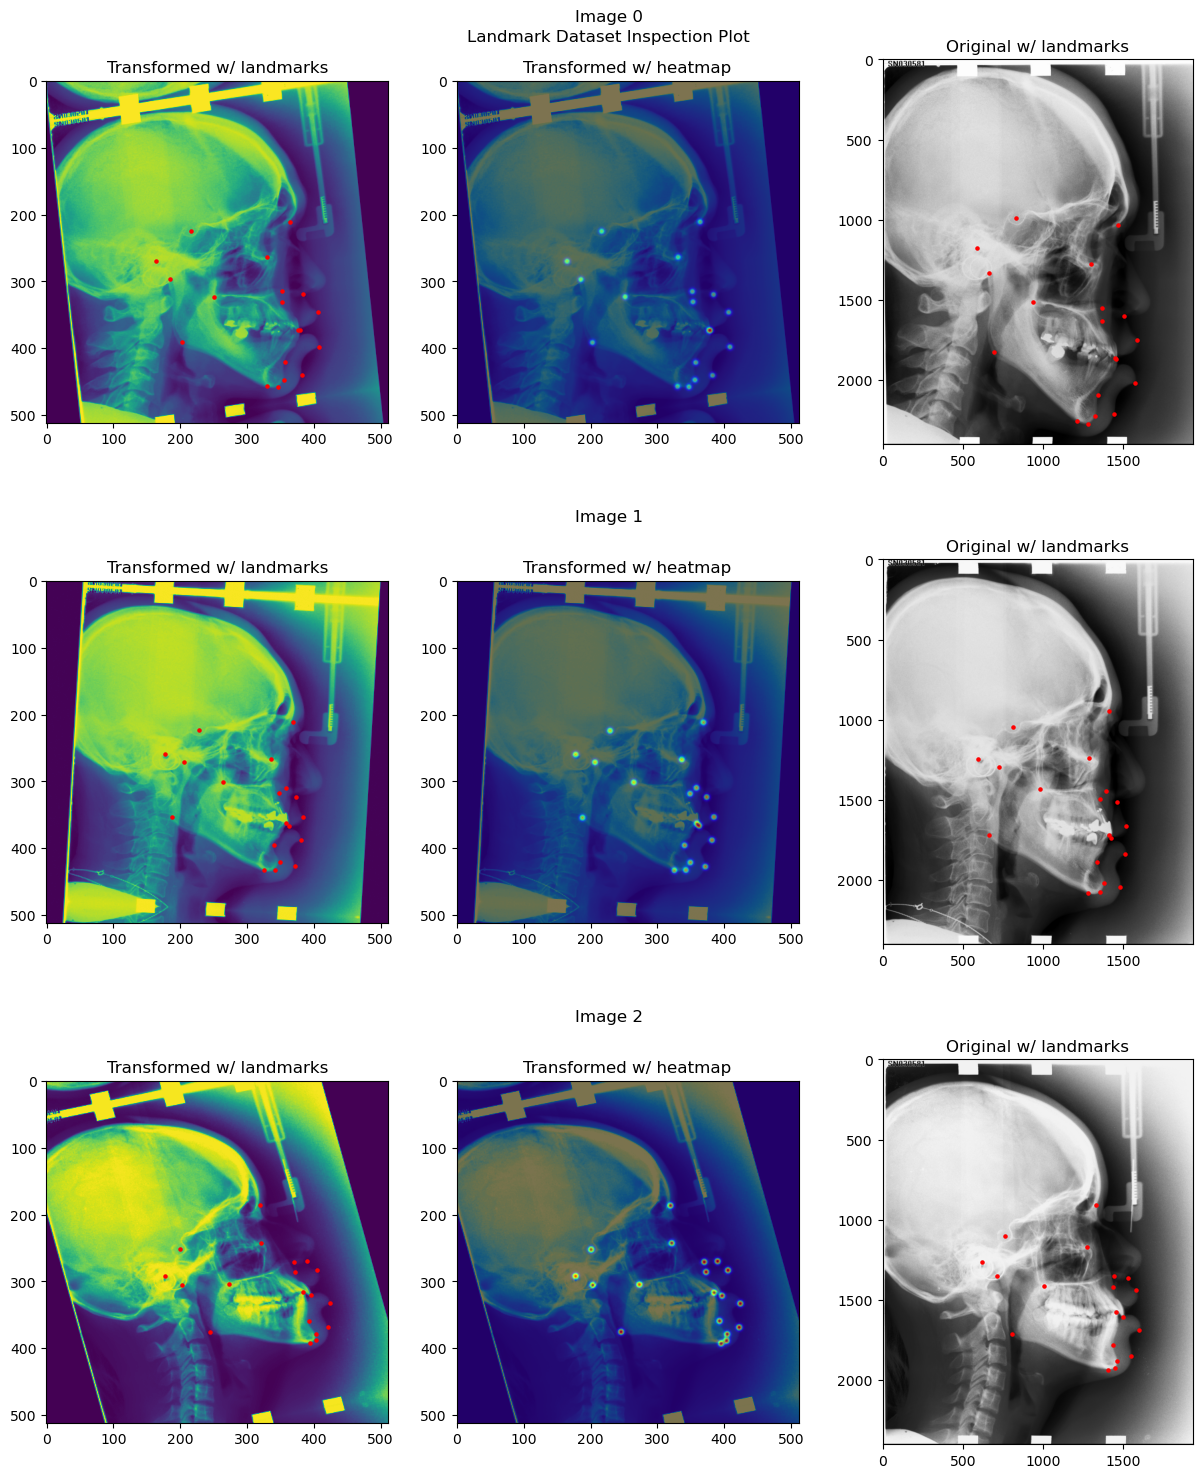

In [8]:
from landmarker.visualize import inspection_plot

# Plot the first 3 images from the training set
heatmap_generator.device = "cpu" # because dataset tensors are still on cpu
inspection_plot(ds, range(3), heatmap_generator=heatmap_generator)
heatmap_generator.device = device # set the desired device back

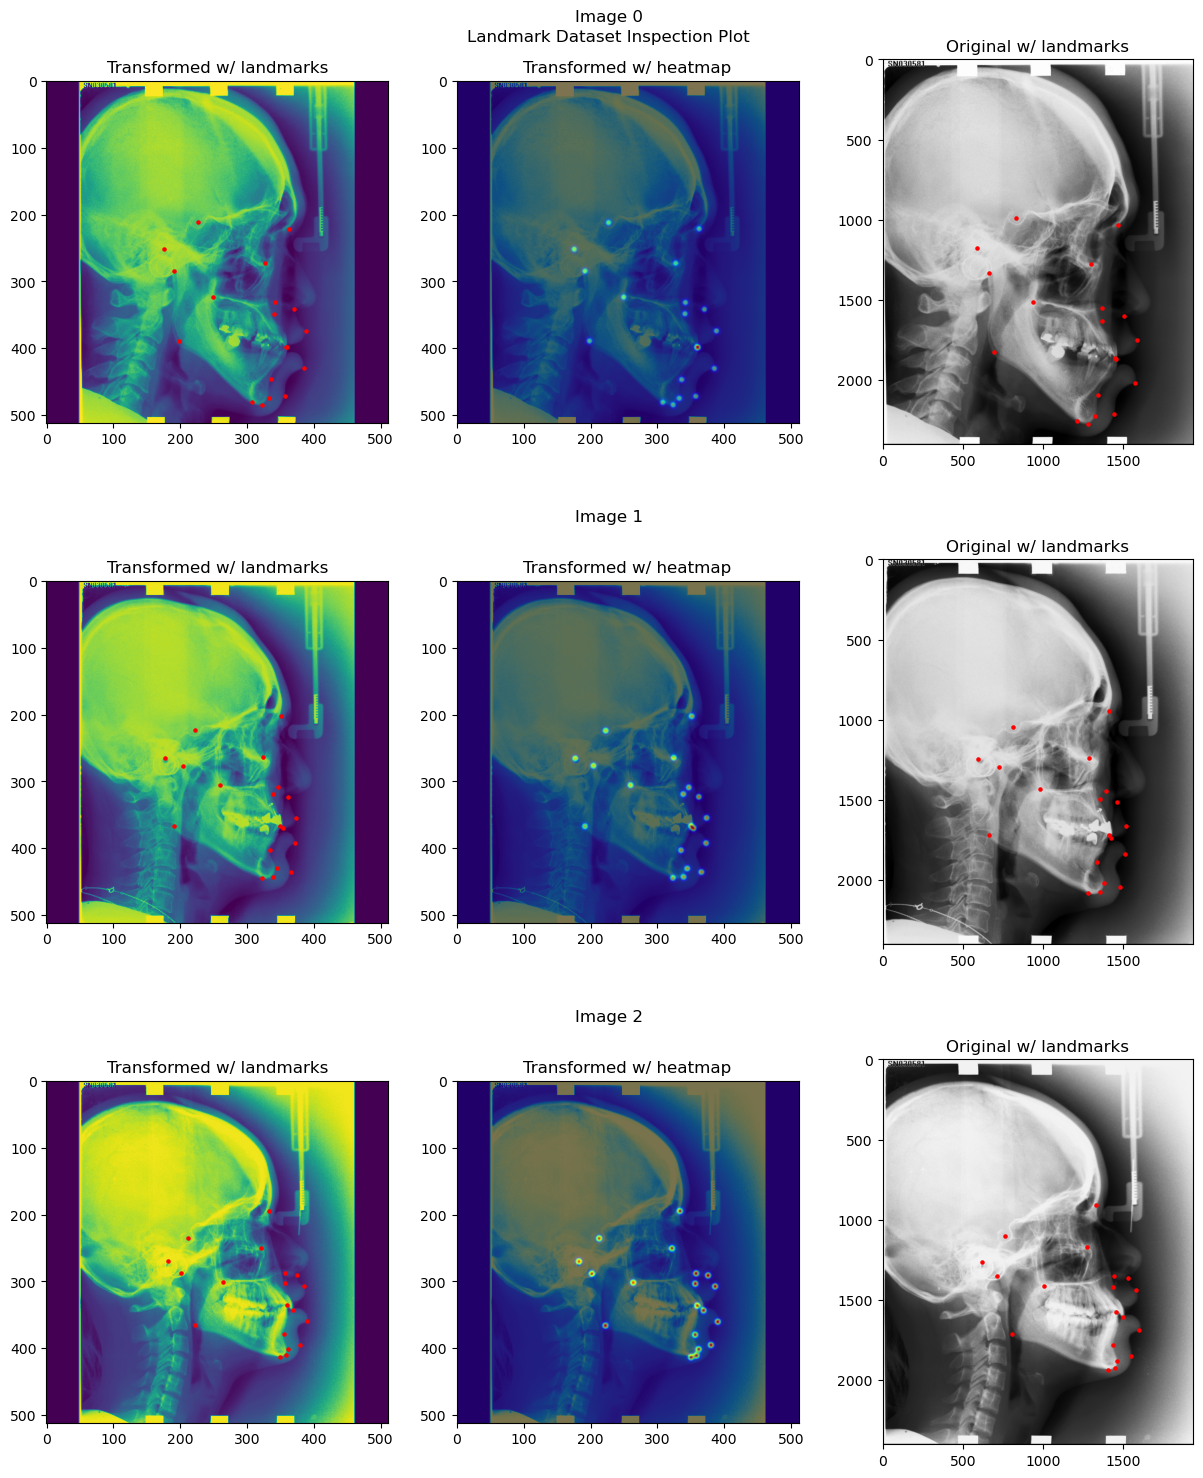

In [9]:
# Plot the first 3 images from dataset without transforms
heatmap_generator.device = "cpu" # because dataset tensors are still on cpu
ds.transform = None
inspection_plot(ds, range(3), heatmap_generator=heatmap_generator)
ds.transform = composed_transformd
heatmap_generator.device = device # set the desired device back

## Training and initializing the SpatialConfiguration model

### Initializing the model, optimizer and loss function

In [10]:
from landmarker.models.spatial_configuration_net import OriginalSpatialConfigurationNet
from landmarker.losses import GeneralizedNormalHeatmapLoss, GaussianHeatmapL2Loss
from landmarker.train import EarlyStopping, SaveBestModel

model = OriginalSpatialConfigurationNet(in_channels=1, out_channels=19).to(device)
print("Number of learnable parameters: {}".format(
    sum(p.numel() for p in model.parameters() if p.requires_grad)))
lr = 1e-6
batch_size = 1
epochs = 1000

optimizer = torch.optim.SGD([
    {'params': model.parameters(), "weight_decay":1e-3},
    {'params': heatmap_generator.sigmas},
    {'params': heatmap_generator.rotation}]
    , lr=lr, momentum=0.99, nesterov=True)

# criterion = GeneralizedNormalHeatmapLoss(
#     alpha=5,
#     distance='l2'
# )
criterion = GaussianHeatmapL2Loss(
    alpha=5
)

early_stopping = EarlyStopping(patience=30, verbose=True)
save_best_model = SaveBestModel(verbose=True)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5,
                                                          patience=10, verbose=True, cooldown=10)

Number of learnable parameters: 6181030


### Setting the data loaders

In [11]:
train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(ds_val, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=0)

### Training the model

In [12]:
from landmarker.heatmap.decoder import heatmap_to_coord
from landmarker.metrics import point_error

def train_epoch(model, heatmap_generator, train_loader, criterion, optimizer, device):
    running_loss = 0
    model.train()
    for i, (images, landmarks, _, _, _, _, _, _) in enumerate(tqdm(train_loader)):
        images = images.to(device)
        landmarks = landmarks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        heatmaps = heatmap_generator(landmarks)
        loss = criterion(outputs, heatmap_generator.sigmas, heatmaps)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

def val_epoch(model, heatmap_generator, val_loader, criterion, device, method="local_soft_argmax"):
    eval_loss = 0
    eval_mpe = 0
    model.eval()
    with torch.no_grad():
        for i, (images, landmarks, _, _, _ , dim_orig, pixel_spacing,
                padding) in enumerate(tqdm(val_loader)):
            images = images.to(device)
            landmarks = landmarks.to(device)
            outputs = model(images)
            dim_orig = dim_orig.to(device)
            pixel_spacing = pixel_spacing.to(device)
            padding = padding.to(device)
            heatmaps = heatmap_generator(landmarks)
            loss = criterion(outputs, heatmap_generator.sigmas, heatmaps)
            offset_coords = outputs.shape[1]-landmarks.shape[1]
            pred_landmarks = heatmap_to_coord(outputs, offset_coords=offset_coords, method=method)
            eval_loss += loss.item()
            eval_mpe += point_error(landmarks, pred_landmarks, images.shape[-2:], dim_orig,
                                    pixel_spacing, padding, reduction="mean")
    return eval_loss / len(val_loader), eval_mpe / len(val_loader)

def train(model, heatmap_generator, train_loader, val_loader, ds, transform, criterion, optimizer, device, epochs=1000):
    for epoch in range(epochs):
        ds.transform = transform
        train_loss = train_epoch(model, heatmap_generator, train_loader, criterion, optimizer, device)
        ds.transform = None
        val_loss, val_mpe = val_epoch(model, heatmap_generator, val_loader, criterion, device)
        print(f"Epoch {epoch+1}/{epochs} - Train loss: {train_loss:.4f} - Val loss: {val_loss:.4f} - Val mpe: {val_mpe:.4f}")
        early_stopping(val_loss)
        save_best_model(val_mpe, model)
        lr_scheduler.step(val_loss)
        if early_stopping.early_stop:
            print(f"Loading best model...")
            model.load_state_dict(torch.load(save_best_model.path))
            break

In [13]:
train(model, heatmap_generator, train_loader, val_loader, ds, composed_transformd, criterion, optimizer, device,
      epochs=epochs)

100%|██████████| 100/100 [00:07<00:00, 13.03it/s]


Epoch 1/1000 - Train loss: 2502.0005 - Val loss: 2460.0886 - Val mpe: 16.0984


100%|██████████| 100/100 [00:07<00:00, 13.13it/s]


Epoch 2/1000 - Train loss: 2416.2396 - Val loss: 2355.6402 - Val mpe: 5.8708
INFO: Val_Loss improved (16.09842300 --> 5.87075424). Saving model ...


100%|██████████| 100/100 [00:07<00:00, 13.15it/s]


Epoch 3/1000 - Train loss: 2320.3651 - Val loss: 2252.0196 - Val mpe: 3.7765
INFO: Val_Loss improved (5.87075424 --> 3.77650952). Saving model ...


100%|██████████| 100/100 [00:07<00:00, 13.18it/s]


Epoch 4/1000 - Train loss: 2241.3421 - Val loss: 2170.1922 - Val mpe: 3.2480
INFO: Val_Loss improved (3.77650952 --> 3.24802995). Saving model ...


100%|██████████| 100/100 [00:07<00:00, 13.11it/s]


Epoch 5/1000 - Train loss: 2191.4752 - Val loss: 2136.4035 - Val mpe: 3.1644
INFO: Val_Loss improved (3.24802995 --> 3.16435409). Saving model ...


100%|██████████| 100/100 [00:07<00:00, 13.05it/s]


Epoch 6/1000 - Train loss: 2138.3780 - Val loss: 2043.5194 - Val mpe: 2.4104
INFO: Val_Loss improved (3.16435409 --> 2.41041231). Saving model ...


100%|██████████| 100/100 [00:07<00:00, 13.07it/s]


Epoch 7/1000 - Train loss: 2111.3214 - Val loss: 2011.7185 - Val mpe: 2.2669
INFO: Val_Loss improved (2.41041231 --> 2.26694703). Saving model ...


100%|██████████| 100/100 [00:07<00:00, 12.99it/s]


Epoch 8/1000 - Train loss: 2061.8907 - Val loss: 1948.8141 - Val mpe: 2.1343
INFO: Val_Loss improved (2.26694703 --> 2.13429523). Saving model ...


100%|██████████| 100/100 [00:07<00:00, 13.07it/s]


Epoch 9/1000 - Train loss: 1994.5533 - Val loss: 1891.7609 - Val mpe: 1.9695
INFO: Val_Loss improved (2.13429523 --> 1.96951354). Saving model ...


100%|██████████| 100/100 [00:07<00:00, 13.09it/s]


Epoch 10/1000 - Train loss: 1936.4082 - Val loss: 1820.2079 - Val mpe: 1.7693
INFO: Val_Loss improved (1.96951354 --> 1.76926875). Saving model ...


100%|██████████| 100/100 [00:07<00:00, 12.97it/s]


Epoch 11/1000 - Train loss: 1882.5334 - Val loss: 1756.2953 - Val mpe: 1.6254
INFO: Val_Loss improved (1.76926875 --> 1.62540758). Saving model ...


100%|██████████| 100/100 [00:07<00:00, 13.05it/s]


Epoch 12/1000 - Train loss: 1837.5068 - Val loss: 1725.9756 - Val mpe: 1.6061
INFO: Val_Loss improved (1.62540758 --> 1.60606337). Saving model ...


100%|██████████| 100/100 [00:07<00:00, 12.97it/s]


Epoch 13/1000 - Train loss: 1803.5645 - Val loss: 1682.9398 - Val mpe: 1.4844
INFO: Val_Loss improved (1.60606337 --> 1.48436594). Saving model ...


100%|██████████| 100/100 [00:07<00:00, 13.13it/s]


Epoch 14/1000 - Train loss: 1751.3267 - Val loss: 1625.8770 - Val mpe: 1.4386
INFO: Val_Loss improved (1.48436594 --> 1.43862391). Saving model ...


100%|██████████| 100/100 [00:07<00:00, 13.00it/s]


Epoch 15/1000 - Train loss: 1703.7325 - Val loss: 1616.9889 - Val mpe: 1.4356
INFO: Val_Loss improved (1.43862391 --> 1.43560576). Saving model ...


100%|██████████| 100/100 [00:07<00:00, 13.20it/s]


Epoch 16/1000 - Train loss: 1681.9078 - Val loss: 1594.6264 - Val mpe: 1.3513
INFO: Val_Loss improved (1.43560576 --> 1.35130310). Saving model ...


100%|██████████| 100/100 [00:07<00:00, 13.01it/s]


Epoch 17/1000 - Train loss: 1635.2474 - Val loss: 1566.1755 - Val mpe: 1.3399
INFO: Val_Loss improved (1.35130310 --> 1.33989978). Saving model ...


100%|██████████| 100/100 [00:07<00:00, 13.02it/s]


Epoch 18/1000 - Train loss: 1620.8349 - Val loss: 1568.1147 - Val mpe: 1.3095
INFO: Early stopping counter                     1 of 30                         [Best Val Loss: 1566.17550171,                             Val Loss: 1568.11466431]
INFO: Val_Loss improved (1.33989978 --> 1.30953109). Saving model ...


100%|██████████| 100/100 [00:07<00:00, 13.11it/s]


Epoch 19/1000 - Train loss: 1606.6994 - Val loss: 1516.1122 - Val mpe: 1.3103


100%|██████████| 100/100 [00:07<00:00, 13.07it/s]


Epoch 20/1000 - Train loss: 1595.0671 - Val loss: 1497.1205 - Val mpe: 1.2789
INFO: Val_Loss improved (1.30953109 --> 1.27893722). Saving model ...


100%|██████████| 100/100 [00:07<00:00, 13.05it/s]


Epoch 21/1000 - Train loss: 1583.1172 - Val loss: 1526.9703 - Val mpe: 1.3125
INFO: Early stopping counter                     1 of 30                         [Best Val Loss: 1497.12045654,                             Val Loss: 1526.97025146]


100%|██████████| 100/100 [00:07<00:00, 13.00it/s]


Epoch 22/1000 - Train loss: 1570.0909 - Val loss: 1491.4588 - Val mpe: 1.2972


100%|██████████| 100/100 [00:07<00:00, 13.05it/s]


Epoch 23/1000 - Train loss: 1553.8700 - Val loss: 1499.5439 - Val mpe: 1.2521
INFO: Early stopping counter                     1 of 30                         [Best Val Loss: 1491.45883667,                             Val Loss: 1499.54393677]
INFO: Val_Loss improved (1.27893722 --> 1.25213683). Saving model ...


100%|██████████| 100/100 [00:07<00:00, 13.03it/s]


Epoch 24/1000 - Train loss: 1545.2085 - Val loss: 1459.4266 - Val mpe: 1.2506
INFO: Val_Loss improved (1.25213683 --> 1.25060284). Saving model ...


100%|██████████| 100/100 [00:07<00:00, 13.10it/s]


Epoch 25/1000 - Train loss: 1521.3849 - Val loss: 1491.8010 - Val mpe: 1.2613
INFO: Early stopping counter                     1 of 30                         [Best Val Loss: 1459.42656738,                             Val Loss: 1491.80104492]


100%|██████████| 100/100 [00:07<00:00, 12.95it/s]


Epoch 26/1000 - Train loss: 1527.8951 - Val loss: 1456.9247 - Val mpe: 1.2808


100%|██████████| 100/100 [00:07<00:00, 13.09it/s]


Epoch 27/1000 - Train loss: 1508.1235 - Val loss: 1449.3879 - Val mpe: 1.2442
INFO: Val_Loss improved (1.25060284 --> 1.24418652). Saving model ...


100%|██████████| 100/100 [00:07<00:00, 12.97it/s]


Epoch 28/1000 - Train loss: 1497.6301 - Val loss: 1430.3492 - Val mpe: 1.2455


100%|██████████| 100/100 [00:07<00:00, 13.01it/s]


Epoch 29/1000 - Train loss: 1488.5035 - Val loss: 1443.5812 - Val mpe: 1.2273
INFO: Early stopping counter                     1 of 30                         [Best Val Loss: 1430.34920898,                             Val Loss: 1443.58122925]
INFO: Val_Loss improved (1.24418652 --> 1.22728920). Saving model ...


100%|██████████| 100/100 [00:07<00:00, 13.07it/s]


Epoch 30/1000 - Train loss: 1471.4200 - Val loss: 1422.7596 - Val mpe: 1.2425


100%|██████████| 100/100 [00:07<00:00, 12.98it/s]


Epoch 31/1000 - Train loss: 1474.2788 - Val loss: 1424.5801 - Val mpe: 1.2381
INFO: Early stopping counter                     1 of 30                         [Best Val Loss: 1422.75956177,                             Val Loss: 1424.58006592]


100%|██████████| 100/100 [00:07<00:00, 13.16it/s]


Epoch 32/1000 - Train loss: 1454.1813 - Val loss: 1406.7071 - Val mpe: 1.2090
INFO: Val_Loss improved (1.22728920 --> 1.20904374). Saving model ...


100%|██████████| 100/100 [00:07<00:00, 12.93it/s]


Epoch 33/1000 - Train loss: 1461.7786 - Val loss: 1408.9387 - Val mpe: 1.2188
INFO: Early stopping counter                     1 of 30                         [Best Val Loss: 1406.70710938,                             Val Loss: 1408.93869629]


100%|██████████| 100/100 [00:07<00:00, 13.09it/s]


Epoch 34/1000 - Train loss: 1446.0020 - Val loss: 1397.2962 - Val mpe: 1.1997
INFO: Val_Loss improved (1.20904374 --> 1.19973338). Saving model ...


100%|██████████| 100/100 [00:07<00:00, 13.00it/s]


Epoch 35/1000 - Train loss: 1438.7904 - Val loss: 1414.1452 - Val mpe: 1.1844
INFO: Early stopping counter                     1 of 30                         [Best Val Loss: 1397.29623291,                             Val Loss: 1414.14515503]
INFO: Val_Loss improved (1.19973338 --> 1.18444276). Saving model ...


100%|██████████| 100/100 [00:07<00:00, 13.09it/s]


Epoch 36/1000 - Train loss: 1418.3194 - Val loss: 1407.8863 - Val mpe: 1.1929
INFO: Early stopping counter                     2 of 30                         [Best Val Loss: 1397.29623291,                             Val Loss: 1407.88629883]


100%|██████████| 100/100 [00:07<00:00, 13.12it/s]


Epoch 37/1000 - Train loss: 1417.2409 - Val loss: 1393.6305 - Val mpe: 1.1765
INFO: Val_Loss improved (1.18444276 --> 1.17651296). Saving model ...


100%|██████████| 100/100 [00:07<00:00, 13.03it/s]


Epoch 38/1000 - Train loss: 1418.8638 - Val loss: 1378.4031 - Val mpe: 1.1594
INFO: Val_Loss improved (1.17651296 --> 1.15940487). Saving model ...


100%|██████████| 100/100 [00:07<00:00, 13.05it/s]


Epoch 39/1000 - Train loss: 1410.4786 - Val loss: 1385.4043 - Val mpe: 1.1683
INFO: Early stopping counter                     1 of 30                         [Best Val Loss: 1378.40312256,                             Val Loss: 1385.40426270]


100%|██████████| 100/100 [00:07<00:00, 13.15it/s]


Epoch 40/1000 - Train loss: 1395.6309 - Val loss: 1372.0832 - Val mpe: 1.1887


100%|██████████| 100/100 [00:07<00:00, 12.95it/s]


Epoch 41/1000 - Train loss: 1387.7436 - Val loss: 1356.2638 - Val mpe: 1.1459
INFO: Val_Loss improved (1.15940487 --> 1.14592314). Saving model ...


100%|██████████| 100/100 [00:07<00:00, 13.09it/s]


Epoch 42/1000 - Train loss: 1397.5923 - Val loss: 1375.4140 - Val mpe: 1.1574
INFO: Early stopping counter                     1 of 30                         [Best Val Loss: 1356.26375000,                             Val Loss: 1375.41404175]


100%|██████████| 100/100 [00:07<00:00, 13.21it/s]


Epoch 43/1000 - Train loss: 1386.1116 - Val loss: 1367.4269 - Val mpe: 1.1763
INFO: Early stopping counter                     2 of 30                         [Best Val Loss: 1356.26375000,                             Val Loss: 1367.42689575]


100%|██████████| 100/100 [00:07<00:00, 13.23it/s]


Epoch 44/1000 - Train loss: 1386.6198 - Val loss: 1379.8658 - Val mpe: 1.1495
INFO: Early stopping counter                     3 of 30                         [Best Val Loss: 1356.26375000,                             Val Loss: 1379.86577271]


100%|██████████| 100/100 [00:07<00:00, 13.12it/s]


Epoch 45/1000 - Train loss: 1379.7977 - Val loss: 1366.4281 - Val mpe: 1.1521
INFO: Early stopping counter                     4 of 30                         [Best Val Loss: 1356.26375000,                             Val Loss: 1366.42814331]


100%|██████████| 100/100 [00:07<00:00, 13.11it/s]


Epoch 46/1000 - Train loss: 1367.9730 - Val loss: 1366.6042 - Val mpe: 1.1355
INFO: Early stopping counter                     5 of 30                         [Best Val Loss: 1356.26375000,                             Val Loss: 1366.60417358]
INFO: Val_Loss improved (1.14592314 --> 1.13547659). Saving model ...


100%|██████████| 100/100 [00:07<00:00, 13.07it/s]


Epoch 47/1000 - Train loss: 1368.4054 - Val loss: 1359.3908 - Val mpe: 1.1507
INFO: Early stopping counter                     6 of 30                         [Best Val Loss: 1356.26375000,                             Val Loss: 1359.39082764]


100%|██████████| 100/100 [00:07<00:00, 13.16it/s]


Epoch 48/1000 - Train loss: 1365.6974 - Val loss: 1358.1459 - Val mpe: 1.1423
INFO: Early stopping counter                     7 of 30                         [Best Val Loss: 1356.26375000,                             Val Loss: 1358.14587280]


100%|██████████| 100/100 [00:07<00:00, 13.23it/s]


Epoch 49/1000 - Train loss: 1365.1489 - Val loss: 1355.7301 - Val mpe: 1.1515


100%|██████████| 100/100 [00:07<00:00, 13.00it/s]


Epoch 50/1000 - Train loss: 1355.7740 - Val loss: 1340.2439 - Val mpe: 1.1321
INFO: Val_Loss improved (1.13547659 --> 1.13205874). Saving model ...


100%|██████████| 100/100 [00:07<00:00, 13.07it/s]


Epoch 51/1000 - Train loss: 1348.7282 - Val loss: 1370.0630 - Val mpe: 1.1460
INFO: Early stopping counter                     1 of 30                         [Best Val Loss: 1340.24387085,                             Val Loss: 1370.06295166]


100%|██████████| 100/100 [00:07<00:00, 13.11it/s]


Epoch 52/1000 - Train loss: 1344.8297 - Val loss: 1343.4959 - Val mpe: 1.1317
INFO: Early stopping counter                     2 of 30                         [Best Val Loss: 1340.24387085,                             Val Loss: 1343.49592773]
INFO: Val_Loss improved (1.13205874 --> 1.13174057). Saving model ...


100%|██████████| 100/100 [00:07<00:00, 13.04it/s]


Epoch 53/1000 - Train loss: 1342.0111 - Val loss: 1346.6251 - Val mpe: 1.1377
INFO: Early stopping counter                     3 of 30                         [Best Val Loss: 1340.24387085,                             Val Loss: 1346.62505737]


100%|██████████| 100/100 [00:07<00:00, 13.07it/s]


Epoch 54/1000 - Train loss: 1345.0947 - Val loss: 1347.2788 - Val mpe: 1.1274
INFO: Early stopping counter                     4 of 30                         [Best Val Loss: 1340.24387085,                             Val Loss: 1347.27879883]
INFO: Val_Loss improved (1.13174057 --> 1.12736833). Saving model ...


100%|██████████| 100/100 [00:07<00:00, 13.09it/s]


Epoch 55/1000 - Train loss: 1358.5512 - Val loss: 1340.7465 - Val mpe: 1.1236
INFO: Early stopping counter                     5 of 30                         [Best Val Loss: 1340.24387085,                             Val Loss: 1340.74646851]
INFO: Val_Loss improved (1.12736833 --> 1.12357593). Saving model ...


100%|██████████| 100/100 [00:07<00:00, 13.00it/s]


Epoch 56/1000 - Train loss: 1333.3749 - Val loss: 1346.8502 - Val mpe: 1.1327
INFO: Early stopping counter                     6 of 30                         [Best Val Loss: 1340.24387085,                             Val Loss: 1346.85021118]


100%|██████████| 100/100 [00:07<00:00, 13.15it/s]


Epoch 57/1000 - Train loss: 1340.8460 - Val loss: 1343.6040 - Val mpe: 1.1544
INFO: Early stopping counter                     7 of 30                         [Best Val Loss: 1340.24387085,                             Val Loss: 1343.60401611]


100%|██████████| 100/100 [00:07<00:00, 13.02it/s]


Epoch 58/1000 - Train loss: 1333.5870 - Val loss: 1370.3228 - Val mpe: 1.1231
INFO: Early stopping counter                     8 of 30                         [Best Val Loss: 1340.24387085,                             Val Loss: 1370.32275879]
INFO: Val_Loss improved (1.12357593 --> 1.12309813). Saving model ...


100%|██████████| 100/100 [00:07<00:00, 13.07it/s]


Epoch 59/1000 - Train loss: 1335.6915 - Val loss: 1339.8849 - Val mpe: 1.1279


100%|██████████| 100/100 [00:07<00:00, 13.09it/s]


Epoch 60/1000 - Train loss: 1323.9412 - Val loss: 1333.9423 - Val mpe: 1.1205
INFO: Val_Loss improved (1.12309813 --> 1.12049019). Saving model ...


100%|██████████| 100/100 [00:07<00:00, 13.04it/s]


Epoch 61/1000 - Train loss: 1314.2453 - Val loss: 1321.5774 - Val mpe: 1.1278


100%|██████████| 100/100 [00:07<00:00, 13.10it/s]


Epoch 62/1000 - Train loss: 1314.0815 - Val loss: 1330.1338 - Val mpe: 1.1259
INFO: Early stopping counter                     1 of 30                         [Best Val Loss: 1321.57744629,                             Val Loss: 1330.13378906]


100%|██████████| 100/100 [00:07<00:00, 13.07it/s]


Epoch 63/1000 - Train loss: 1320.2291 - Val loss: 1336.2184 - Val mpe: 1.1253
INFO: Early stopping counter                     2 of 30                         [Best Val Loss: 1321.57744629,                             Val Loss: 1336.21838379]


100%|██████████| 100/100 [00:07<00:00, 13.13it/s]


Epoch 64/1000 - Train loss: 1313.1414 - Val loss: 1350.9936 - Val mpe: 1.0972
INFO: Early stopping counter                     3 of 30                         [Best Val Loss: 1321.57744629,                             Val Loss: 1350.99360474]
INFO: Val_Loss improved (1.12049019 --> 1.09715974). Saving model ...


100%|██████████| 100/100 [00:07<00:00, 12.94it/s]


Epoch 65/1000 - Train loss: 1307.8940 - Val loss: 1321.6070 - Val mpe: 1.1169
INFO: Early stopping counter                     4 of 30                         [Best Val Loss: 1321.57744629,                             Val Loss: 1321.60702148]


100%|██████████| 100/100 [00:07<00:00, 13.01it/s]


Epoch 66/1000 - Train loss: 1305.1851 - Val loss: 1373.4092 - Val mpe: 1.1374
INFO: Early stopping counter                     5 of 30                         [Best Val Loss: 1321.57744629,                             Val Loss: 1373.40915161]


100%|██████████| 100/100 [00:07<00:00, 13.00it/s]


Epoch 67/1000 - Train loss: 1301.0570 - Val loss: 1349.5007 - Val mpe: 1.1215
INFO: Early stopping counter                     6 of 30                         [Best Val Loss: 1321.57744629,                             Val Loss: 1349.50070190]


100%|██████████| 100/100 [00:07<00:00, 13.05it/s]


Epoch 68/1000 - Train loss: 1302.3307 - Val loss: 1328.4090 - Val mpe: 1.1126
INFO: Early stopping counter                     7 of 30                         [Best Val Loss: 1321.57744629,                             Val Loss: 1328.40902222]


100%|██████████| 100/100 [00:07<00:00, 12.96it/s]


Epoch 69/1000 - Train loss: 1288.1582 - Val loss: 1324.6254 - Val mpe: 1.1231
INFO: Early stopping counter                     8 of 30                         [Best Val Loss: 1321.57744629,                             Val Loss: 1324.62542236]


100%|██████████| 100/100 [00:07<00:00, 13.04it/s]


Epoch 70/1000 - Train loss: 1281.6894 - Val loss: 1328.8693 - Val mpe: 1.1042
INFO: Early stopping counter                     9 of 30                         [Best Val Loss: 1321.57744629,                             Val Loss: 1328.86928955]


100%|██████████| 100/100 [00:07<00:00, 13.05it/s]


Epoch 71/1000 - Train loss: 1290.9518 - Val loss: 1331.3726 - Val mpe: 1.1328
INFO: Early stopping counter                     10 of 30                         [Best Val Loss: 1321.57744629,                             Val Loss: 1331.37260132]


100%|██████████| 100/100 [00:07<00:00, 13.06it/s]


Epoch 72/1000 - Train loss: 1284.5962 - Val loss: 1316.2549 - Val mpe: 1.1093


100%|██████████| 100/100 [00:07<00:00, 13.09it/s]


Epoch 73/1000 - Train loss: 1275.4287 - Val loss: 1320.4346 - Val mpe: 1.1164
INFO: Early stopping counter                     1 of 30                         [Best Val Loss: 1316.25491577,                             Val Loss: 1320.43460083]


100%|██████████| 100/100 [00:07<00:00, 13.07it/s]


Epoch 74/1000 - Train loss: 1298.7429 - Val loss: 1351.2367 - Val mpe: 1.1003
INFO: Early stopping counter                     2 of 30                         [Best Val Loss: 1316.25491577,                             Val Loss: 1351.23668335]


100%|██████████| 100/100 [00:07<00:00, 13.06it/s]


Epoch 75/1000 - Train loss: 1285.6036 - Val loss: 1314.8303 - Val mpe: 1.0998


100%|██████████| 100/100 [00:07<00:00, 13.04it/s]


Epoch 76/1000 - Train loss: 1273.1496 - Val loss: 1313.5217 - Val mpe: 1.1053


100%|██████████| 100/100 [00:07<00:00, 13.08it/s]


Epoch 77/1000 - Train loss: 1267.6121 - Val loss: 1321.3954 - Val mpe: 1.0984
INFO: Early stopping counter                     1 of 30                         [Best Val Loss: 1313.52169922,                             Val Loss: 1321.39538086]


100%|██████████| 100/100 [00:07<00:00, 13.08it/s]


Epoch 78/1000 - Train loss: 1274.0952 - Val loss: 1328.9485 - Val mpe: 1.1170
INFO: Early stopping counter                     2 of 30                         [Best Val Loss: 1313.52169922,                             Val Loss: 1328.94847900]


100%|██████████| 100/100 [00:07<00:00, 12.96it/s]


Epoch 79/1000 - Train loss: 1271.9613 - Val loss: 1356.3434 - Val mpe: 1.1090
INFO: Early stopping counter                     3 of 30                         [Best Val Loss: 1313.52169922,                             Val Loss: 1356.34341187]


100%|██████████| 100/100 [00:07<00:00, 12.97it/s]


Epoch 80/1000 - Train loss: 1279.2557 - Val loss: 1317.3899 - Val mpe: 1.1158
INFO: Early stopping counter                     4 of 30                         [Best Val Loss: 1313.52169922,                             Val Loss: 1317.38994873]


100%|██████████| 100/100 [00:07<00:00, 13.02it/s]


Epoch 81/1000 - Train loss: 1267.8095 - Val loss: 1308.5733 - Val mpe: 1.1184


100%|██████████| 100/100 [00:07<00:00, 13.14it/s]


Epoch 82/1000 - Train loss: 1261.7041 - Val loss: 1327.1334 - Val mpe: 1.1123
INFO: Early stopping counter                     1 of 30                         [Best Val Loss: 1308.57333496,                             Val Loss: 1327.13344727]


100%|██████████| 100/100 [00:07<00:00, 13.03it/s]


Epoch 83/1000 - Train loss: 1274.4589 - Val loss: 1333.2320 - Val mpe: 1.1088
INFO: Early stopping counter                     2 of 30                         [Best Val Loss: 1308.57333496,                             Val Loss: 1333.23197998]


100%|██████████| 100/100 [00:07<00:00, 13.09it/s]


Epoch 84/1000 - Train loss: 1272.2213 - Val loss: 1340.9727 - Val mpe: 1.1027
INFO: Early stopping counter                     3 of 30                         [Best Val Loss: 1308.57333496,                             Val Loss: 1340.97271729]


100%|██████████| 100/100 [00:07<00:00, 13.03it/s]


Epoch 85/1000 - Train loss: 1271.5085 - Val loss: 1338.7190 - Val mpe: 1.1143
INFO: Early stopping counter                     4 of 30                         [Best Val Loss: 1308.57333496,                             Val Loss: 1338.71901855]


100%|██████████| 100/100 [00:07<00:00, 13.02it/s]


Epoch 86/1000 - Train loss: 1258.0164 - Val loss: 1314.8320 - Val mpe: 1.0959
INFO: Early stopping counter                     5 of 30                         [Best Val Loss: 1308.57333496,                             Val Loss: 1314.83195312]
INFO: Val_Loss improved (1.09715974 --> 1.09590042). Saving model ...


100%|██████████| 100/100 [00:07<00:00, 13.10it/s]


Epoch 87/1000 - Train loss: 1247.1574 - Val loss: 1317.9223 - Val mpe: 1.0946
INFO: Early stopping counter                     6 of 30                         [Best Val Loss: 1308.57333496,                             Val Loss: 1317.92227783]
INFO: Val_Loss improved (1.09590042 --> 1.09464967). Saving model ...


100%|██████████| 100/100 [00:07<00:00, 13.14it/s]


Epoch 88/1000 - Train loss: 1251.5698 - Val loss: 1313.9952 - Val mpe: 1.1009
INFO: Early stopping counter                     7 of 30                         [Best Val Loss: 1308.57333496,                             Val Loss: 1313.99521729]


100%|██████████| 100/100 [00:07<00:00, 13.13it/s]


Epoch 89/1000 - Train loss: 1269.3163 - Val loss: 1309.7888 - Val mpe: 1.0984
INFO: Early stopping counter                     8 of 30                         [Best Val Loss: 1308.57333496,                             Val Loss: 1309.78875977]


100%|██████████| 100/100 [00:07<00:00, 13.06it/s]


Epoch 90/1000 - Train loss: 1245.3513 - Val loss: 1317.2120 - Val mpe: 1.1001
INFO: Early stopping counter                     9 of 30                         [Best Val Loss: 1308.57333496,                             Val Loss: 1317.21202881]


100%|██████████| 100/100 [00:07<00:00, 12.96it/s]


Epoch 91/1000 - Train loss: 1251.9910 - Val loss: 1330.2805 - Val mpe: 1.0953
INFO: Early stopping counter                     10 of 30                         [Best Val Loss: 1308.57333496,                             Val Loss: 1330.28048096]


100%|██████████| 100/100 [00:07<00:00, 13.15it/s]


Epoch 92/1000 - Train loss: 1252.1102 - Val loss: 1318.0697 - Val mpe: 1.0938
INFO: Early stopping counter                     11 of 30                         [Best Val Loss: 1308.57333496,                             Val Loss: 1318.06968628]
INFO: Val_Loss improved (1.09464967 --> 1.09380889). Saving model ...
Epoch 00092: reducing learning rate of group 0 to 5.0000e-07.
Epoch 00092: reducing learning rate of group 1 to 5.0000e-07.
Epoch 00092: reducing learning rate of group 2 to 5.0000e-07.


100%|██████████| 100/100 [00:07<00:00, 13.08it/s]


Epoch 93/1000 - Train loss: 1222.1097 - Val loss: 1306.0507 - Val mpe: 1.0800
INFO: Val_Loss improved (1.09380889 --> 1.07999444). Saving model ...


100%|██████████| 100/100 [00:07<00:00, 12.97it/s]


Epoch 94/1000 - Train loss: 1212.1322 - Val loss: 1300.3770 - Val mpe: 1.0870


100%|██████████| 100/100 [00:07<00:00, 13.07it/s]


Epoch 95/1000 - Train loss: 1208.6308 - Val loss: 1296.9834 - Val mpe: 1.0859


100%|██████████| 100/100 [00:07<00:00, 13.06it/s]


Epoch 96/1000 - Train loss: 1208.7230 - Val loss: 1295.2366 - Val mpe: 1.0975


100%|██████████| 100/100 [00:07<00:00, 13.10it/s]


Epoch 97/1000 - Train loss: 1196.7126 - Val loss: 1293.2379 - Val mpe: 1.0837


100%|██████████| 100/100 [00:07<00:00, 13.11it/s]


Epoch 98/1000 - Train loss: 1193.7193 - Val loss: 1310.4274 - Val mpe: 1.0983
INFO: Early stopping counter                     1 of 30                         [Best Val Loss: 1293.23787720,                             Val Loss: 1310.42743286]


100%|██████████| 100/100 [00:07<00:00, 12.96it/s]


Epoch 99/1000 - Train loss: 1182.2580 - Val loss: 1296.3301 - Val mpe: 1.0927
INFO: Early stopping counter                     2 of 30                         [Best Val Loss: 1293.23787720,                             Val Loss: 1296.33005737]


100%|██████████| 100/100 [00:07<00:00, 13.11it/s]


Epoch 100/1000 - Train loss: 1181.9321 - Val loss: 1310.0047 - Val mpe: 1.0863
INFO: Early stopping counter                     3 of 30                         [Best Val Loss: 1293.23787720,                             Val Loss: 1310.00468506]


100%|██████████| 100/100 [00:07<00:00, 13.06it/s]


Epoch 101/1000 - Train loss: 1190.4808 - Val loss: 1303.8710 - Val mpe: 1.0911
INFO: Early stopping counter                     4 of 30                         [Best Val Loss: 1293.23787720,                             Val Loss: 1303.87102661]


100%|██████████| 100/100 [00:07<00:00, 13.18it/s]


Epoch 102/1000 - Train loss: 1185.5258 - Val loss: 1292.3101 - Val mpe: 1.0817


100%|██████████| 100/100 [00:07<00:00, 12.99it/s]


Epoch 103/1000 - Train loss: 1173.0228 - Val loss: 1307.6817 - Val mpe: 1.0829
INFO: Early stopping counter                     1 of 30                         [Best Val Loss: 1292.31011597,                             Val Loss: 1307.68169922]


100%|██████████| 100/100 [00:07<00:00, 13.01it/s]


Epoch 104/1000 - Train loss: 1188.0529 - Val loss: 1312.0361 - Val mpe: 1.0770
INFO: Early stopping counter                     2 of 30                         [Best Val Loss: 1292.31011597,                             Val Loss: 1312.03606689]
INFO: Val_Loss improved (1.07999444 --> 1.07701480). Saving model ...


100%|██████████| 100/100 [00:07<00:00, 13.18it/s]


Epoch 105/1000 - Train loss: 1177.4519 - Val loss: 1307.0063 - Val mpe: 1.0979
INFO: Early stopping counter                     3 of 30                         [Best Val Loss: 1292.31011597,                             Val Loss: 1307.00627319]


100%|██████████| 100/100 [00:07<00:00, 13.03it/s]


Epoch 106/1000 - Train loss: 1177.2376 - Val loss: 1301.4065 - Val mpe: 1.0733
INFO: Early stopping counter                     4 of 30                         [Best Val Loss: 1292.31011597,                             Val Loss: 1301.40650635]
INFO: Val_Loss improved (1.07701480 --> 1.07330239). Saving model ...


100%|██████████| 100/100 [00:07<00:00, 13.10it/s]


Epoch 107/1000 - Train loss: 1171.2305 - Val loss: 1303.0434 - Val mpe: 1.0776
INFO: Early stopping counter                     5 of 30                         [Best Val Loss: 1292.31011597,                             Val Loss: 1303.04340698]


100%|██████████| 100/100 [00:07<00:00, 13.11it/s]


Epoch 108/1000 - Train loss: 1171.5627 - Val loss: 1312.2510 - Val mpe: 1.0905
INFO: Early stopping counter                     6 of 30                         [Best Val Loss: 1292.31011597,                             Val Loss: 1312.25104492]


100%|██████████| 100/100 [00:07<00:00, 13.04it/s]


Epoch 109/1000 - Train loss: 1168.3722 - Val loss: 1303.3688 - Val mpe: 1.0868
INFO: Early stopping counter                     7 of 30                         [Best Val Loss: 1292.31011597,                             Val Loss: 1303.36884644]


100%|██████████| 100/100 [00:07<00:00, 13.06it/s]


Epoch 110/1000 - Train loss: 1164.4457 - Val loss: 1293.8121 - Val mpe: 1.0876
INFO: Early stopping counter                     8 of 30                         [Best Val Loss: 1292.31011597,                             Val Loss: 1293.81214355]


100%|██████████| 100/100 [00:07<00:00, 13.00it/s]


Epoch 111/1000 - Train loss: 1182.9000 - Val loss: 1302.3196 - Val mpe: 1.0809
INFO: Early stopping counter                     9 of 30                         [Best Val Loss: 1292.31011597,                             Val Loss: 1302.31962402]


100%|██████████| 100/100 [00:07<00:00, 13.06it/s]


Epoch 112/1000 - Train loss: 1178.0874 - Val loss: 1304.6534 - Val mpe: 1.0735
INFO: Early stopping counter                     10 of 30                         [Best Val Loss: 1292.31011597,                             Val Loss: 1304.65339478]


100%|██████████| 100/100 [00:07<00:00, 13.04it/s]


Epoch 113/1000 - Train loss: 1162.1789 - Val loss: 1299.9327 - Val mpe: 1.0846
INFO: Early stopping counter                     11 of 30                         [Best Val Loss: 1292.31011597,                             Val Loss: 1299.93274841]
Epoch 00113: reducing learning rate of group 0 to 2.5000e-07.
Epoch 00113: reducing learning rate of group 1 to 2.5000e-07.
Epoch 00113: reducing learning rate of group 2 to 2.5000e-07.


100%|██████████| 100/100 [00:07<00:00, 13.14it/s]


Epoch 114/1000 - Train loss: 1148.8411 - Val loss: 1318.4970 - Val mpe: 1.0841
INFO: Early stopping counter                     12 of 30                         [Best Val Loss: 1292.31011597,                             Val Loss: 1318.49701782]


100%|██████████| 100/100 [00:07<00:00, 12.98it/s]


Epoch 115/1000 - Train loss: 1149.8977 - Val loss: 1299.6151 - Val mpe: 1.0809
INFO: Early stopping counter                     13 of 30                         [Best Val Loss: 1292.31011597,                             Val Loss: 1299.61513916]


100%|██████████| 100/100 [00:07<00:00, 13.03it/s]


Epoch 116/1000 - Train loss: 1145.0817 - Val loss: 1293.6832 - Val mpe: 1.0743
INFO: Early stopping counter                     14 of 30                         [Best Val Loss: 1292.31011597,                             Val Loss: 1293.68324341]


100%|██████████| 100/100 [00:07<00:00, 12.98it/s]


Epoch 117/1000 - Train loss: 1140.4063 - Val loss: 1303.3208 - Val mpe: 1.0810
INFO: Early stopping counter                     15 of 30                         [Best Val Loss: 1292.31011597,                             Val Loss: 1303.32078735]


100%|██████████| 100/100 [00:07<00:00, 13.05it/s]


Epoch 118/1000 - Train loss: 1141.1708 - Val loss: 1299.1383 - Val mpe: 1.0898
INFO: Early stopping counter                     16 of 30                         [Best Val Loss: 1292.31011597,                             Val Loss: 1299.13831299]


100%|██████████| 100/100 [00:07<00:00, 13.17it/s]


Epoch 119/1000 - Train loss: 1133.0845 - Val loss: 1291.9228 - Val mpe: 1.0815


100%|██████████| 100/100 [00:07<00:00, 13.16it/s]


Epoch 120/1000 - Train loss: 1132.9069 - Val loss: 1301.7748 - Val mpe: 1.0783
INFO: Early stopping counter                     1 of 30                         [Best Val Loss: 1291.92279297,                             Val Loss: 1301.77478760]


100%|██████████| 100/100 [00:07<00:00, 13.06it/s]


Epoch 121/1000 - Train loss: 1130.9459 - Val loss: 1288.3164 - Val mpe: 1.0861


100%|██████████| 100/100 [00:07<00:00, 13.10it/s]


Epoch 122/1000 - Train loss: 1138.8856 - Val loss: 1297.6129 - Val mpe: 1.0860
INFO: Early stopping counter                     1 of 30                         [Best Val Loss: 1288.31641235,                             Val Loss: 1297.61292847]


100%|██████████| 100/100 [00:07<00:00, 13.01it/s]


Epoch 123/1000 - Train loss: 1143.3367 - Val loss: 1295.7684 - Val mpe: 1.0874
INFO: Early stopping counter                     2 of 30                         [Best Val Loss: 1288.31641235,                             Val Loss: 1295.76844055]


100%|██████████| 100/100 [00:07<00:00, 13.02it/s]


Epoch 124/1000 - Train loss: 1137.5545 - Val loss: 1294.1737 - Val mpe: 1.0849
INFO: Early stopping counter                     3 of 30                         [Best Val Loss: 1288.31641235,                             Val Loss: 1294.17369202]


100%|██████████| 100/100 [00:07<00:00, 13.09it/s]


Epoch 125/1000 - Train loss: 1127.5459 - Val loss: 1288.6652 - Val mpe: 1.0862
INFO: Early stopping counter                     4 of 30                         [Best Val Loss: 1288.31641235,                             Val Loss: 1288.66521118]


100%|██████████| 100/100 [00:07<00:00, 13.24it/s]


Epoch 126/1000 - Train loss: 1136.7763 - Val loss: 1299.4486 - Val mpe: 1.0921
INFO: Early stopping counter                     5 of 30                         [Best Val Loss: 1288.31641235,                             Val Loss: 1299.44862122]


100%|██████████| 100/100 [00:07<00:00, 13.09it/s]


Epoch 127/1000 - Train loss: 1119.9524 - Val loss: 1307.2672 - Val mpe: 1.0806
INFO: Early stopping counter                     6 of 30                         [Best Val Loss: 1288.31641235,                             Val Loss: 1307.26723511]


100%|██████████| 100/100 [00:07<00:00, 13.08it/s]


Epoch 128/1000 - Train loss: 1137.8505 - Val loss: 1297.5988 - Val mpe: 1.0831
INFO: Early stopping counter                     7 of 30                         [Best Val Loss: 1288.31641235,                             Val Loss: 1297.59880371]


100%|██████████| 100/100 [00:07<00:00, 13.11it/s]


Epoch 129/1000 - Train loss: 1124.5146 - Val loss: 1295.0771 - Val mpe: 1.0786
INFO: Early stopping counter                     8 of 30                         [Best Val Loss: 1288.31641235,                             Val Loss: 1295.07709229]


100%|██████████| 100/100 [00:07<00:00, 13.17it/s]


Epoch 130/1000 - Train loss: 1125.8533 - Val loss: 1304.2342 - Val mpe: 1.0882
INFO: Early stopping counter                     9 of 30                         [Best Val Loss: 1288.31641235,                             Val Loss: 1304.23424072]


100%|██████████| 100/100 [00:07<00:00, 13.06it/s]


Epoch 131/1000 - Train loss: 1113.3909 - Val loss: 1301.1338 - Val mpe: 1.0801
INFO: Early stopping counter                     10 of 30                         [Best Val Loss: 1288.31641235,                             Val Loss: 1301.13377197]


100%|██████████| 100/100 [00:07<00:00, 13.00it/s]


Epoch 132/1000 - Train loss: 1119.6914 - Val loss: 1295.0891 - Val mpe: 1.0785
INFO: Early stopping counter                     11 of 30                         [Best Val Loss: 1288.31641235,                             Val Loss: 1295.08909668]


100%|██████████| 100/100 [00:07<00:00, 13.12it/s]


Epoch 133/1000 - Train loss: 1118.8289 - Val loss: 1302.7000 - Val mpe: 1.0827
INFO: Early stopping counter                     12 of 30                         [Best Val Loss: 1288.31641235,                             Val Loss: 1302.70003967]


100%|██████████| 100/100 [00:07<00:00, 13.04it/s]


Epoch 134/1000 - Train loss: 1125.3919 - Val loss: 1304.5798 - Val mpe: 1.0822
INFO: Early stopping counter                     13 of 30                         [Best Val Loss: 1288.31641235,                             Val Loss: 1304.57979126]
Epoch 00134: reducing learning rate of group 0 to 1.2500e-07.
Epoch 00134: reducing learning rate of group 1 to 1.2500e-07.
Epoch 00134: reducing learning rate of group 2 to 1.2500e-07.


100%|██████████| 100/100 [00:07<00:00, 13.17it/s]


Epoch 135/1000 - Train loss: 1120.5080 - Val loss: 1287.6325 - Val mpe: 1.0900


100%|██████████| 100/100 [00:07<00:00, 13.02it/s]


Epoch 136/1000 - Train loss: 1112.8956 - Val loss: 1299.6225 - Val mpe: 1.0847
INFO: Early stopping counter                     1 of 30                         [Best Val Loss: 1287.63249084,                             Val Loss: 1299.62250366]


100%|██████████| 100/100 [00:07<00:00, 13.07it/s]


Epoch 137/1000 - Train loss: 1105.3387 - Val loss: 1300.3365 - Val mpe: 1.0812
INFO: Early stopping counter                     2 of 30                         [Best Val Loss: 1287.63249084,                             Val Loss: 1300.33646851]


100%|██████████| 100/100 [00:07<00:00, 13.20it/s]


Epoch 138/1000 - Train loss: 1100.3838 - Val loss: 1296.2457 - Val mpe: 1.0831
INFO: Early stopping counter                     3 of 30                         [Best Val Loss: 1287.63249084,                             Val Loss: 1296.24566284]


100%|██████████| 100/100 [00:07<00:00, 13.16it/s]


Epoch 139/1000 - Train loss: 1105.9494 - Val loss: 1296.8610 - Val mpe: 1.0874
INFO: Early stopping counter                     4 of 30                         [Best Val Loss: 1287.63249084,                             Val Loss: 1296.86104309]


100%|██████████| 100/100 [00:07<00:00, 13.22it/s]


Epoch 140/1000 - Train loss: 1106.7504 - Val loss: 1298.0793 - Val mpe: 1.0897
INFO: Early stopping counter                     5 of 30                         [Best Val Loss: 1287.63249084,                             Val Loss: 1298.07929199]


100%|██████████| 100/100 [00:07<00:00, 13.14it/s]


Epoch 141/1000 - Train loss: 1097.4185 - Val loss: 1299.5552 - Val mpe: 1.0859
INFO: Early stopping counter                     6 of 30                         [Best Val Loss: 1287.63249084,                             Val Loss: 1299.55520264]


100%|██████████| 100/100 [00:07<00:00, 13.05it/s]


Epoch 142/1000 - Train loss: 1105.6962 - Val loss: 1298.0726 - Val mpe: 1.0911
INFO: Early stopping counter                     7 of 30                         [Best Val Loss: 1287.63249084,                             Val Loss: 1298.07258911]


100%|██████████| 100/100 [00:07<00:00, 13.07it/s]


Epoch 143/1000 - Train loss: 1100.0773 - Val loss: 1303.3372 - Val mpe: 1.0850
INFO: Early stopping counter                     8 of 30                         [Best Val Loss: 1287.63249084,                             Val Loss: 1303.33718384]


100%|██████████| 100/100 [00:07<00:00, 12.99it/s]


Epoch 144/1000 - Train loss: 1096.0509 - Val loss: 1300.8561 - Val mpe: 1.0780
INFO: Early stopping counter                     9 of 30                         [Best Val Loss: 1287.63249084,                             Val Loss: 1300.85610168]


100%|██████████| 100/100 [00:07<00:00, 13.00it/s]


Epoch 145/1000 - Train loss: 1099.5819 - Val loss: 1299.6213 - Val mpe: 1.0841
INFO: Early stopping counter                     10 of 30                         [Best Val Loss: 1287.63249084,                             Val Loss: 1299.62129700]


100%|██████████| 100/100 [00:07<00:00, 13.12it/s]


Epoch 146/1000 - Train loss: 1087.6018 - Val loss: 1295.7990 - Val mpe: 1.0823
INFO: Early stopping counter                     11 of 30                         [Best Val Loss: 1287.63249084,                             Val Loss: 1295.79904541]


100%|██████████| 100/100 [00:07<00:00, 13.10it/s]


Epoch 147/1000 - Train loss: 1087.3660 - Val loss: 1299.7433 - Val mpe: 1.0868
INFO: Early stopping counter                     12 of 30                         [Best Val Loss: 1287.63249084,                             Val Loss: 1299.74333008]


100%|██████████| 100/100 [00:07<00:00, 13.08it/s]


Epoch 148/1000 - Train loss: 1096.4897 - Val loss: 1308.9072 - Val mpe: 1.0844
INFO: Early stopping counter                     13 of 30                         [Best Val Loss: 1287.63249084,                             Val Loss: 1308.90724426]


100%|██████████| 100/100 [00:07<00:00, 13.07it/s]


Epoch 149/1000 - Train loss: 1099.9345 - Val loss: 1306.3984 - Val mpe: 1.0826
INFO: Early stopping counter                     14 of 30                         [Best Val Loss: 1287.63249084,                             Val Loss: 1306.39841125]


100%|██████████| 100/100 [00:07<00:00, 13.04it/s]


Epoch 150/1000 - Train loss: 1104.8305 - Val loss: 1305.1052 - Val mpe: 1.0872
INFO: Early stopping counter                     15 of 30                         [Best Val Loss: 1287.63249084,                             Val Loss: 1305.10524841]


100%|██████████| 100/100 [00:07<00:00, 12.99it/s]


Epoch 151/1000 - Train loss: 1092.6764 - Val loss: 1301.9654 - Val mpe: 1.0845
INFO: Early stopping counter                     16 of 30                         [Best Val Loss: 1287.63249084,                             Val Loss: 1301.96540222]


100%|██████████| 100/100 [00:07<00:00, 13.08it/s]


Epoch 152/1000 - Train loss: 1092.6454 - Val loss: 1307.2558 - Val mpe: 1.0875
INFO: Early stopping counter                     17 of 30                         [Best Val Loss: 1287.63249084,                             Val Loss: 1307.25581116]


100%|██████████| 100/100 [00:07<00:00, 13.02it/s]


Epoch 153/1000 - Train loss: 1094.2362 - Val loss: 1292.1501 - Val mpe: 1.0844
INFO: Early stopping counter                     18 of 30                         [Best Val Loss: 1287.63249084,                             Val Loss: 1292.15008301]


100%|██████████| 100/100 [00:07<00:00, 13.05it/s]


Epoch 154/1000 - Train loss: 1099.1114 - Val loss: 1295.5731 - Val mpe: 1.0803
INFO: Early stopping counter                     19 of 30                         [Best Val Loss: 1287.63249084,                             Val Loss: 1295.57311707]


100%|██████████| 100/100 [00:07<00:00, 12.97it/s]


Epoch 155/1000 - Train loss: 1089.4263 - Val loss: 1302.5926 - Val mpe: 1.0878
INFO: Early stopping counter                     20 of 30                         [Best Val Loss: 1287.63249084,                             Val Loss: 1302.59259888]
Epoch 00155: reducing learning rate of group 0 to 6.2500e-08.
Epoch 00155: reducing learning rate of group 1 to 6.2500e-08.
Epoch 00155: reducing learning rate of group 2 to 6.2500e-08.


100%|██████████| 100/100 [00:07<00:00, 13.03it/s]


Epoch 156/1000 - Train loss: 1094.2453 - Val loss: 1302.0712 - Val mpe: 1.0809
INFO: Early stopping counter                     21 of 30                         [Best Val Loss: 1287.63249084,                             Val Loss: 1302.07116028]


100%|██████████| 100/100 [00:07<00:00, 13.18it/s]


Epoch 157/1000 - Train loss: 1084.5893 - Val loss: 1295.4143 - Val mpe: 1.0801
INFO: Early stopping counter                     22 of 30                         [Best Val Loss: 1287.63249084,                             Val Loss: 1295.41431030]


100%|██████████| 100/100 [00:07<00:00, 13.03it/s]


Epoch 158/1000 - Train loss: 1090.9135 - Val loss: 1299.7678 - Val mpe: 1.0858
INFO: Early stopping counter                     23 of 30                         [Best Val Loss: 1287.63249084,                             Val Loss: 1299.76776855]


100%|██████████| 100/100 [00:07<00:00, 13.10it/s]


Epoch 159/1000 - Train loss: 1079.0250 - Val loss: 1300.7329 - Val mpe: 1.0859
INFO: Early stopping counter                     24 of 30                         [Best Val Loss: 1287.63249084,                             Val Loss: 1300.73285461]


100%|██████████| 100/100 [00:07<00:00, 13.07it/s]


Epoch 160/1000 - Train loss: 1083.0852 - Val loss: 1296.9035 - Val mpe: 1.0879
INFO: Early stopping counter                     25 of 30                         [Best Val Loss: 1287.63249084,                             Val Loss: 1296.90354736]


100%|██████████| 100/100 [00:07<00:00, 13.05it/s]


Epoch 161/1000 - Train loss: 1077.0447 - Val loss: 1298.1467 - Val mpe: 1.0831
INFO: Early stopping counter                     26 of 30                         [Best Val Loss: 1287.63249084,                             Val Loss: 1298.14672302]


100%|██████████| 100/100 [00:07<00:00, 13.05it/s]


Epoch 162/1000 - Train loss: 1085.5905 - Val loss: 1300.0181 - Val mpe: 1.0830
INFO: Early stopping counter                     27 of 30                         [Best Val Loss: 1287.63249084,                             Val Loss: 1300.01809509]


100%|██████████| 100/100 [00:07<00:00, 13.03it/s]


Epoch 163/1000 - Train loss: 1083.1181 - Val loss: 1298.4638 - Val mpe: 1.0838
INFO: Early stopping counter                     28 of 30                         [Best Val Loss: 1287.63249084,                             Val Loss: 1298.46378235]


100%|██████████| 100/100 [00:07<00:00, 13.10it/s]


Epoch 164/1000 - Train loss: 1090.0683 - Val loss: 1299.8173 - Val mpe: 1.0802
INFO: Early stopping counter                     29 of 30                         [Best Val Loss: 1287.63249084,                             Val Loss: 1299.81727051]


100%|██████████| 100/100 [00:07<00:00, 13.02it/s]


Epoch 165/1000 - Train loss: 1085.9051 - Val loss: 1301.8318 - Val mpe: 1.0869
INFO: Early stopping counter                     30 of 30                         [Best Val Loss: 1287.63249084,                             Val Loss: 1301.83181152]
INFO: Early stopping DONE!
INFO: Best Val Loss: 1287.63249084
Loading best model...


## Evaluating the model

In [14]:
pred_landmarks = []
true_landmarks = []
dim_origs = []
pixel_spacings = []
paddings = []
test_mpe = 0
model.eval()
with torch.no_grad():
    for i, (images, landmarks, affine_matrixs, _, _ ,
        dim_orig, pixel_spacing, padding) in enumerate(tqdm(test_loader)):
        images = images.to(device)
        landmarks = landmarks.to(device)
        dim_orig = dim_orig.to(device)
        pixel_spacing = pixel_spacing.to(device)
        padding = padding.to(device)
        outputs = model(images)
        # heatmap = heatmap_generator(landmarks)
        offset_coords = outputs.shape[1]-landmarks.shape[1]
        pred_landmark = heatmap_to_coord(outputs, offset_coords=offset_coords,
                                        method="local_soft_argmax")
        test_mpe += point_error(landmarks, pred_landmark, images.shape[-2:], dim_orig,
                                pixel_spacing, padding, reduction="mean")
        pred_landmarks.append(pred_landmark.cpu())
        true_landmarks.append(landmarks.cpu())
        dim_origs.append(dim_orig.cpu())
        pixel_spacings.append(pixel_spacing.cpu())
        paddings.append(padding.cpu())

pred_landmarks = torch.cat(pred_landmarks)
true_landmarks = torch.cat(true_landmarks)
dim_origs = torch.cat(dim_origs)
pixel_spacings = torch.cat(pixel_spacings)
paddings = torch.cat(paddings)

test_mpe /= len(test_loader)

print(f"Test Mean PE: {test_mpe:.4f}")

100%|██████████| 100/100 [00:06<00:00, 15.84it/s]

Test Mean PE: 1.0885


In [15]:
from landmarker.metrics import sdr

sdr_test = sdr([2.0, 2.5, 3.0, 4.0], true_landmarks=true_landmarks, pred_landmarks=pred_landmarks,
               dim=(512, 512), dim_orig=dim_origs.int(), pixel_spacing=pixel_spacings, padding=paddings)
for key in sdr_test:
    print(f"SDR for {key}mm: {sdr_test[key]:.4f}")

SDR for 2.0mm: 88.4211
SDR for 2.5mm: 92.1579
SDR for 3.0mm: 94.5789
SDR for 4.0mm: 97.6316


In [15]:
from landmarker.metrics import sdr

sdr_test = sdr([2.0, 2.5, 3.0, 4.0], true_landmarks=true_landmarks, pred_landmarks=pred_landmarks,
               dim=(512, 512), dim_orig=dim_origs.int(), pixel_spacing=pixel_spacings, padding=paddings)
for key in sdr_test:
    print(f"SDR for {key}mm: {sdr_test[key]:.4f}")

SDR for 2.0mm: 88.4211
SDR for 2.5mm: 92.1579
SDR for 3.0mm: 94.5789
SDR for 4.0mm: 97.6316


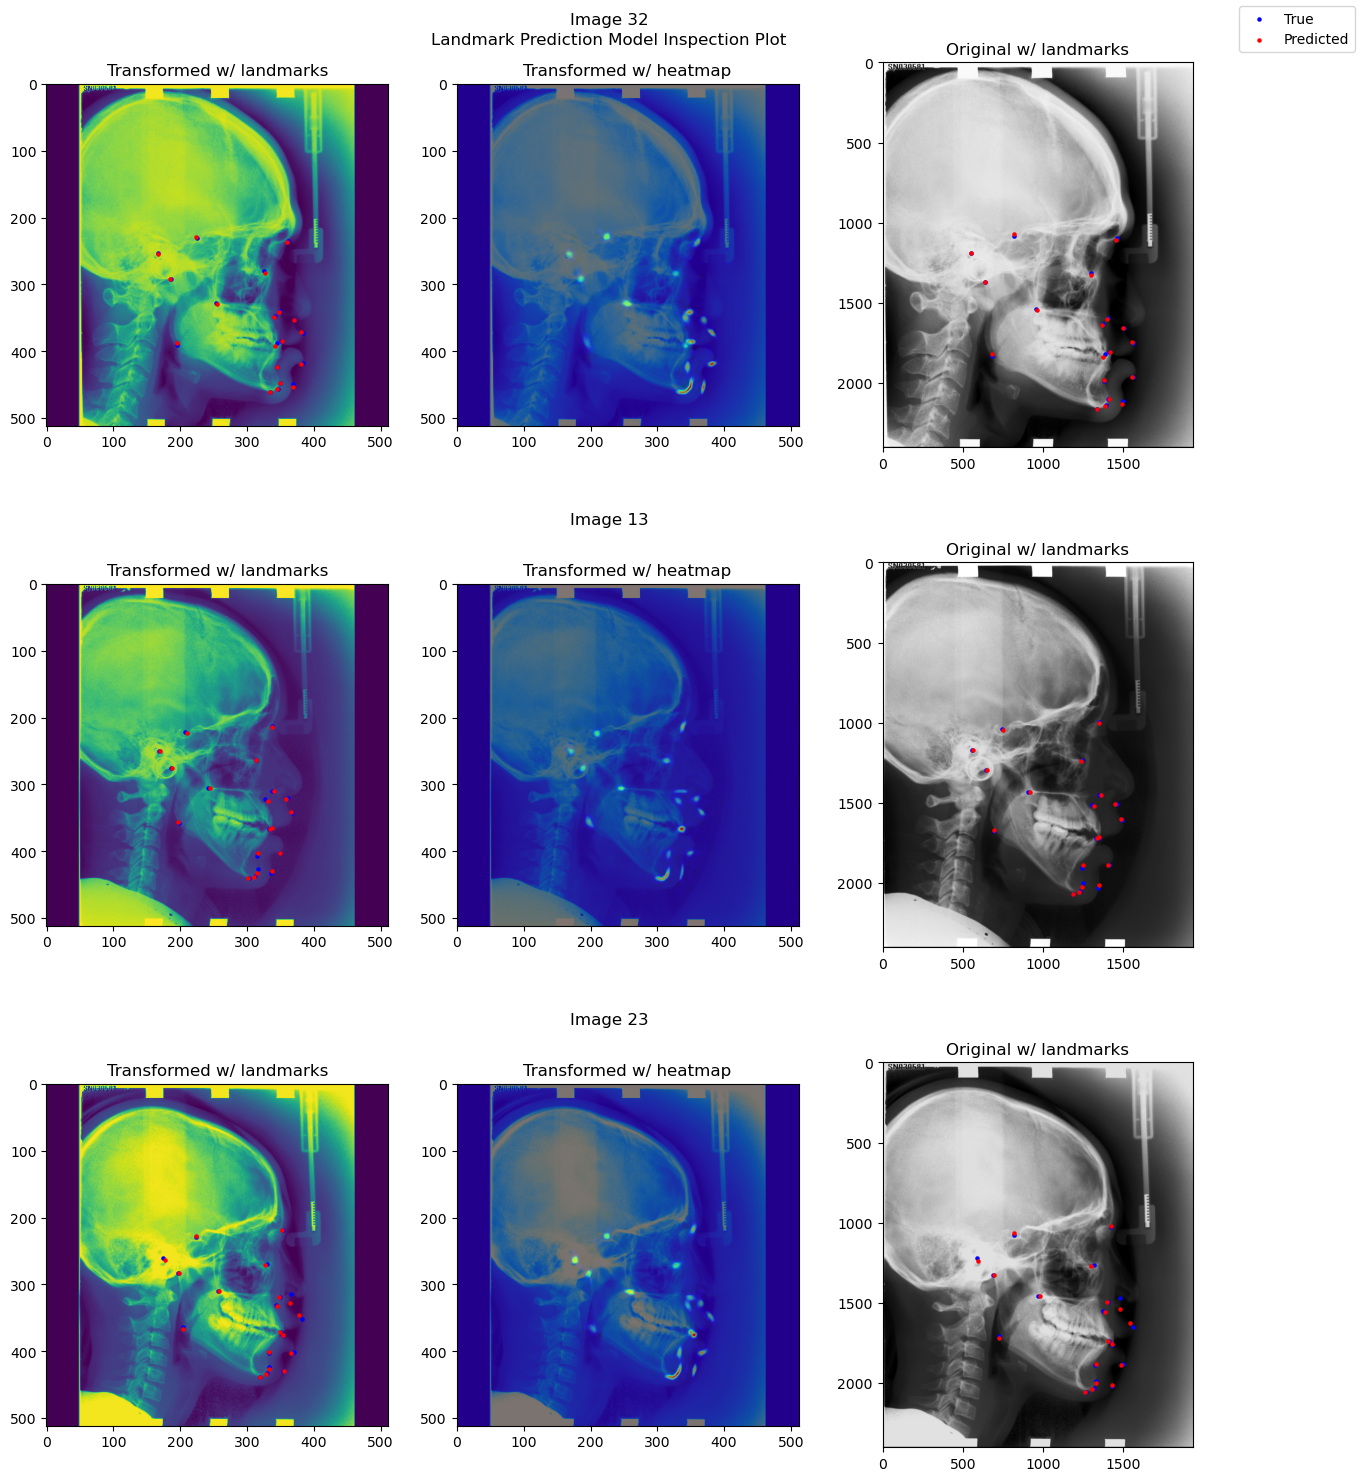

In [20]:
from landmarker.visualize.utils import prediction_inspect_plot

model.eval()
model.to("cpu")
prediction_inspect_plot(ds, model, ds_test.indices[:3])

In [22]:
from landmarker.visualize import detection_report

detection_report(true_landmarks, pred_landmarks, dim=(512, 512), dim_orig=dim_origs.int(),
                    pixel_spacing=pixel_spacings, padding=paddings, class_names=ds.class_names,
                    radius=[2.0, 2.5, 3.0, 4.0], digits=2)

Detection report:
1# Point-to-point error (PE) statistics:
Class               Mean PE   Median PE Std PE    Min       Max       
----------------------------------------------------------------------
landmark_0          0.71      0.61      0.43      0.01      2.33      
landmark_1          1.09      0.68      1.33      0.06      8.42      
landmark_2          1.22      0.86      1.17      0.08      5.13      
landmark_3          1.50      1.02      1.58      0.18      8.13      
landmark_4          1.36      1.08      0.96      0.14      4.64      
landmark_5          1.04      0.80      0.76      0.05      3.28      
landmark_6          0.89      0.86      0.58      0.05      2.77      
landmark_7          0.78      0.60      0.56      0.03      2.69      
landmark_8          0.76      0.61      0.51      0.02      2.24      
landmark_9          2.16      1.82      1.47      0.10      6.26      
landmark_10         0.80      0.63      0.68      0.08      4.46      
landmark_11       

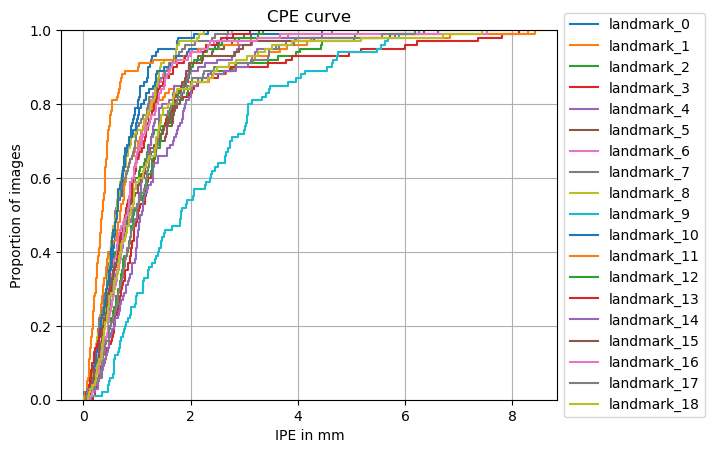

In [23]:
from landmarker.visualize import plot_cpe

plot_cpe(true_landmarks, pred_landmarks, dim=(512, 512), dim_orig=dim_origs.int(),
                    pixel_spacing=pixel_spacings, padding=paddings, class_names=ds.class_names,
                    group=False, title="CPE curve", save_path=None,
                    stat='proportion', unit='mm', kind='ecdf')